In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np
from functools import partial

import warnings
warnings.filterwarnings('ignore')

from probatus.feature_elimination import ShapRFECV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV


import talib.abstract as ta
from scipy.stats import linregress, entropy

import matplotlib.pyplot as plt

from source.backward_fs import backward_by_fi, select_feature_index
from source.feature_generation_ta import generate_features
from source.TE import transfer_entropy
from source.optimizing import objective_lgbm_model
from source.pipeline import pipe

In [4]:
# optuna==3.3.0
# xgboost==1.6.2
# mlflow
# probatus==1.5.1
# lightgbm==4.5.0

import talib
talib.__version__

'0.6.1'

# Задание

В рамках проекта №2 требуется реализовать автоматизированный пайплайн для прогнозирования значений верменного ряда на следуюбщий день.
Ряды представляют из себя срезы в обозначенные моменты времени притоков, оттоков и сальдо показателя, связанного с потоками ликвидности Банка
Прогноз требуется строить для значения сальдо (разнинцы между притоками и оттоками)
Заказчик модели высказал пожелание, чтобы ошибка прогноза составляла не более 0.42 в абсолютном значении


**Требования к модели:**
1. Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
2. Модель может использовать внешние факторы (см подсказки)
3. Модель должна иметь модуль отбора признаков. Метод отбора должен быть болеее стабильным относительно альтернатив. Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные. При этом как минимум одна из альтернатив должа исследовать нелинейную зависимость.
4. Модель должна втоматически подбирать гиперпараметры, оптимизируя целевую метрику
5. Для модели должна быть подобрана частота калиброки, если модель калибруется долго, и проверена ее достаточность
6. Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
7. Модель должна автоматически дообучаться. Все модули должны работать без ручных корректировок. Выбор периода для дообучения должен быть обоснован.
8. В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на на ручное управление процессом/внеплановое дообучение

**Подсказки:**
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

**Описание бизнес-процесса:**
1. Прогнозная величина позволяет установить сальдо поступлений и списаний за день.
2. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
3. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
4. В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

# Загрузка данных

In [5]:
df = pd.read_excel('Project 2_2023.xlsx')
df['Date'] = pd.to_datetime(df['Date'])

df['target_Income'] = df['Income'].shift(1) # предсказание следующего дня
df['target_Outcome'] = df['Outcome'].shift(1)

df.head()

,Date,Income,Outcome,Balance,target_Income,target_Outcome
0,2017-01-09,1.343028,1.487865,-0.155904,NaN,NaN
1,2017-01-10,1.068610,1.194182,-0.125572,1.343028,1.487865
2,2017-01-11,0.944429,0.936663,0.007767,1.068610,1.194182
3,2017-01-12,1.672202,0.875379,0.800391,0.944429,0.936663
4,2017-01-13,0.955924,0.975645,-0.019721,1.672202,0.875379


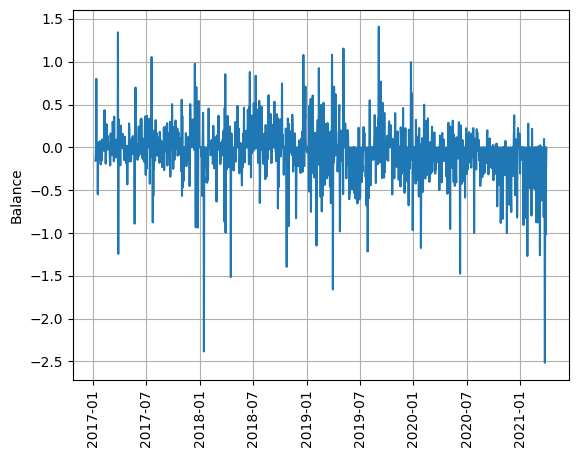

In [5]:
plt.plot(df['Date'], df['Balance'])
plt.xticks(rotation = 90)
plt.ylabel('Balance')
plt.grid()

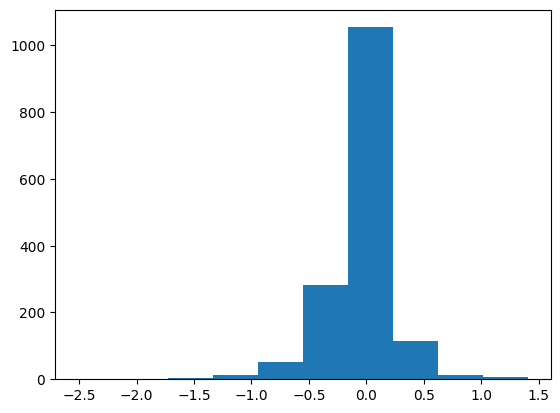

In [6]:
plt.hist(df['Balance']);

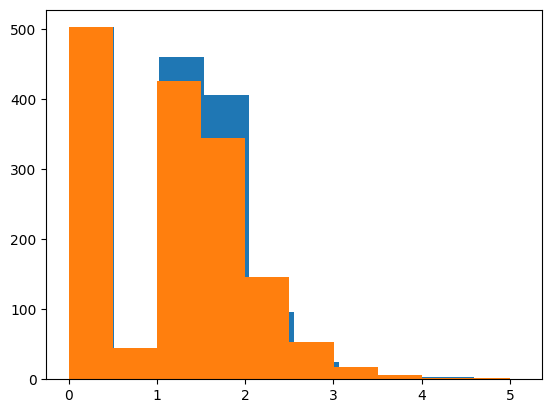

In [7]:
plt.hist(df['Income'])
plt.hist(df['Outcome']);

# Генерация фичей теханализа

In [6]:
df_new = generate_features(df)
df_new['period'] = df_new['%-year'].astype(str) +'-' + df_new['%-month'].astype(str)
df_new = df_new.iloc[1:] # удаляем первую строчку тк там нет лага таргета

# real_balance
df_new["Balance"] = df_new["Income"] - df_new["Outcome"]

longlist = [x for x in df_new.columns if '%' in x]
print(len(longlist))

# проверка на адекватность фичей
# df_new[longlist].mean()
# df_new[longlist].isna().sum() / df_new[longlist].shape[0] * 100

66


In [7]:
class ModelRunner:
    '''
    Класс для прогона модели

    inplace_type - чем заполнять пропуски
    test_days - сколько дней включать в тестовую выборку
    min_train_days - сколько дней включать в тренировочную выборку
    '''
    def __init__(self,
                dataframe: pd.DataFrame,  # df_new
                train_sample_format: str = 'increasing', # 'increasing' or 'sliding_window'
                inplace_type: str = '-1e10', 
                test_days: int = 30, 
                min_train_days: int = 60):

        self.dataframe = dataframe
        self.train_sample_format = train_sample_format
        self.inplace_type = inplace_type # 'mean'
        self.test_days = test_days
        self.min_train_days = min_train_days


        # Инициализация
        self.df_results = pd.DataFrame(columns = ['Date', 'train_period', 'test_period',
                                                  'MAE_Balance', 'Retrained',
                                                  'best_model_income', 'best_model_outcome',
                                                  'selected_features_in', 'selected_features_out'])

    def run_loop(self) -> pd.DataFrame:
        '''
        Цикл по дням
        '''
        dict_in = None # нужная заглушка
        prev_mae = None # нужная заглушка
        
        for idx in range(self.min_train_days, len(self.dataframe) - self.test_days + 1): # [:50]
            train_end_idx = idx
            test_end_idx = idx + self.test_days

            if self.train_sample_format == 'increasing':
                df_train = self.dataframe.iloc[:train_end_idx]
                df_test  = self.dataframe.iloc[train_end_idx:test_end_idx]

            if self.train_sample_format == 'sliding_window':
                df_train = self.dataframe.iloc[train_end_idx-59:train_end_idx]
                df_test  = self.dataframe.iloc[train_end_idx:test_end_idx]

            train_period = df_train['Date'].min().strftime('%Y-%m-%d') + '/' + df_train['Date'].max().strftime('%Y-%m-%d')
            test_period = df_test['Date'].min().strftime('%Y-%m-%d') + '/' + df_test['Date'].max().strftime('%Y-%m-%d')
            print('period:', train_period, '->', test_period)

            train, valid = train_test_split(df_train, test_size=0.2, random_state = 42)
            # train
            x_train = train[longlist]
            y_train_in = train['target_Income']
            y_train_out = train['target_Outcome']
            # valid
            x_valid = valid[longlist]
            y_valid_in = valid['target_Income']
            y_valid_out = valid['target_Outcome']
            # test
            x_test = df_test[longlist]
            y_test_in = df_test['target_Income']
            y_test_out = df_test['target_Outcome']
            
            # заполнение пропусков
            if self.inplace_type == '-1e10':
                x_train.fillna(-1e10, inplace=True)
                x_valid.fillna(-1e10, inplace=True)
                x_test.fillna(-1e10, inplace=True)
                
            if self.inplace_type == 'mean':
                x_train.fillna(x_train.mean(), inplace=True)
                x_valid.fillna(x_train.mean(), inplace=True)
                x_test.fillna(x_train.mean(), inplace=True)

            if dict_in is None: # прогоняем пайп 1й раз
                dict_in = pipe(x_train, x_valid, x_test,
                               y_train_in, y_valid_in, y_test_in, 
                               longlist)
                dict_out = pipe(x_train, x_valid, x_test,
                                y_train_out, y_valid_out, y_test_out,
                                longlist)
                retrained = True
            else:
                retrained = False

            # preds and mae
            y_pred_in = self.return_predictions(pipe_dict = dict_in, x_test = x_test)
            y_pred_out = self.return_predictions(pipe_dict = dict_out, x_test = x_test)
            df_test['predicted_Balance'] = y_pred_in - y_pred_out
            mae = mean_absolute_error(df_test["Balance"], df_test['predicted_Balance'])
            
            # Compare to previous MAE
            if prev_mae is not None:
                mae_pct_change = (mae - prev_mae) / prev_mae
                print('LINE:', prev_mae, mae, mae_pct_change)

                if (mae_pct_change >= 0.01) | self.check_increase(series = self.df_results['MAE_Balance'], threshold = 0.05, n_last_points = 5): 
                    dict_in = pipe(x_train, x_valid, x_test,
                                    y_train_in, y_valid_in, y_test_in, 
                                    longlist)
                    dict_out = pipe(x_train, x_valid, x_test,
                                        y_train_out, y_valid_out, y_test_out,
                                        longlist)
                    retrained = True

                    # preds and mae
                    y_pred_in = self.return_predictions(pipe_dict = dict_in, x_test = x_test)
                    y_pred_out = self.return_predictions(pipe_dict = dict_out, x_test = x_test)
                    df_test['predicted_Balance'] = y_pred_in - y_pred_out
                    mae = mean_absolute_error(df_test["Balance"], df_test['predicted_Balance'])

            # Store results
            self.df_results.loc[len(self.df_results)+ 1] = [df_test["Date"].iloc[-1],
                                                            train_period,
                                                            test_period,
                                                            mae,
                                                            retrained,
                                                            dict_in['best_model'] if retrained else None,
                                                            dict_out['best_model'] if retrained else None,
                                                            dict_in['features'] if retrained else None,
                                                            dict_out['features'] if retrained else None
                                                        ]

            prev_mae = mae

            print('--------------------------------')

        return self.df_results


    def check_increase(self, series, threshold=0.05, n_last_points=5):
        '''
        Проверяет было ли увеличение метрики на 
        заданный процент последние n_last_points точек
        '''
        pct_changes = series.pct_change()
        last_10_pct = pct_changes.iloc[-n_last_points:]
        if last_10_pct.isna().any():
            return False
        sum_increases = last_10_pct.sum()
        return sum_increases > threshold
    
    def plot_results(self, plot_retrain_points = False):
        '''
        Визуализирует self.df_results
        '''
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(self.df_results['Date'], self.df_results['MAE_Balance'], label='MAE_Balance')
        plt.axhline(0.42, color = 'black', label = '0.42')
        if plot_retrain_points:
            for d in self.df_results[self.df_results['Retrained'].eq(True)]['Date'].values:
                ax.axvline(x=d, color='red', linestyle='--', alpha=0.3)
        plt.xticks(rotation=90)
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()
        plt.grid()
        plt.show()
    
    @staticmethod
    def return_predictions(pipe_dict: dict, x_test: pd.DataFrame) -> np.array:
        '''
        Для того чтобы возвращать для Income и Outcome предикты
        '''

        selected_features_in = pipe_dict['features']
        model = pipe_dict['model']

        if isinstance(model, Lasso):
            X_test_scaled = pipe_dict['X_test_scaled']
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(x_test[selected_features_in])

        return y_pred

In [4]:
mr = ModelRunner(dataframe=df_new, train_sample_format = 'sliding_window')

NameError: name 'df_new' is not defined

In [197]:
mr.run_loop()

period: 2017-01-11/2017-03-10 -> 2017-03-11/2017-04-09
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.397634
2       df_metric_lgbm     0.323831
3      df_metric_lasso     0.102784
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.385047
2       df_metric_lgbm     0.333374
3      df_metric_lasso     0.224137
best_algo = Lasso
--------------------------------
period: 2017-01-12/2017-03-11 -> 2017-03-12/2017-04-10
LINE: 0.21361136341300033 0.19849009456090022 -0.07078869124983933
--------------------------------
period: 2017-01-13/2017-03-12 -> 2017-03-13/2017-04-11
LINE: 0.19849009456090022 0.2210140182701315 0.11347631104241604
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.635294
2       df_metric_lgbm     0.395162
3      df_metric_lasso     0.108338
best_algo = Lasso
df_m:
                     k  test_metric
1  df_metric_lgbm_corr     0.610492
2       df_metric_lgbm     0.369742
3      df_metric_la

,Date,train_period,test_period,MAE_Balance,Retrained,best_model_income,best_model_outcome,selected_features_in,selected_features_out
1,2017-04-09,2017-01-11/2017-03-10,2017-03-11/2017-04-09,0.213611,True,Lasso,Lasso,"[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d...","[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d..."
2,2017-04-10,2017-01-12/2017-03-11,2017-03-12/2017-04-10,0.198490,False,None,None,None,None
3,2017-04-11,2017-01-13/2017-03-12,2017-03-13/2017-04-11,0.189292,True,Lasso,Lasso,"[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d...","[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d..."
4,2017-04-12,2017-01-14/2017-03-13,2017-03-14/2017-04-12,0.187245,False,None,None,None,None
5,2017-04-13,2017-01-15/2017-03-14,2017-03-15/2017-04-13,0.181270,False,None,None,None,None
...,...,...,...,...,...,...,...,...,...
1449,2021-03-27,2020-12-29/2021-02-25,2021-02-26/2021-03-27,1.198733,True,LGBM_corr,Lasso,"[%-stoch-k-14, %-ema-7, %-stoch-k-7, %-macd, %...","[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d..."
1450,2021-03-28,2020-12-30/2021-02-26,2021-02-27/2021-03-28,0.980271,True,Lasso,LGBM,"[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d...","[%-macd_hist, %-diff-1, %-atr-7, %-sqrt_price,..."
1451,2021-03-29,2020-12-31/2021-02-27,2021-02-28/2021-03-29,0.978588,True,Lasso,LGBM,"[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d...","[%-sqrt_price, %-macd_hist, %-atr-7, %-stoch-k..."
1452,2021-03-30,2021-01-01/2021-02-28,2021-03-01/2021-03-30,0.996977,True,Lasso,LGBM_corr,"[%-sqrt_price, %-rsi-7, %-stoch-k-7, %-stoch-d...","[%-stoch-k-7, %-stoch-k-14, %-macd_hist, %-ema..."


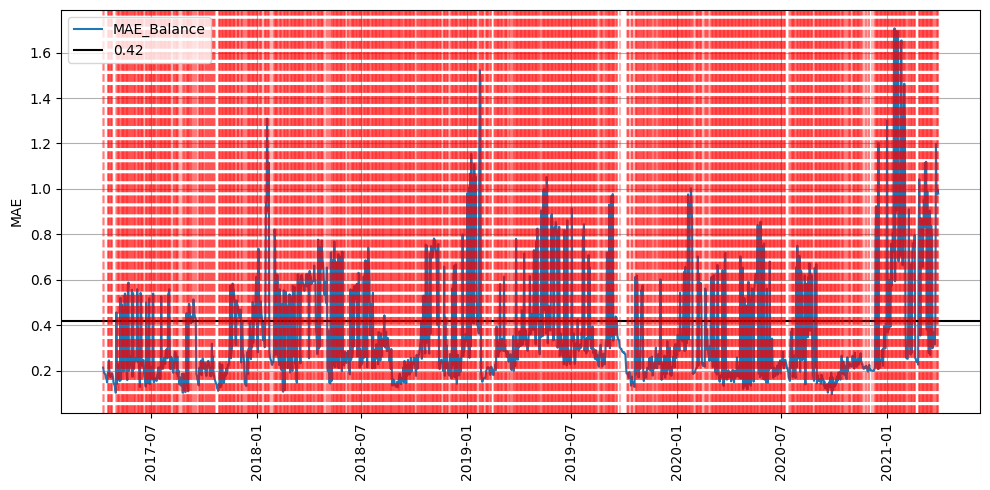

In [ ]:
mr.plot_results(plot_retrain_points=True)

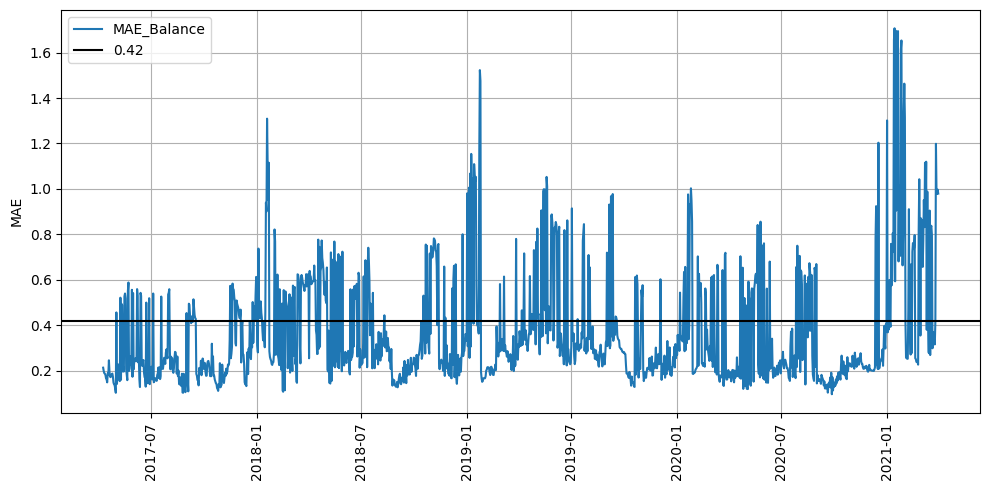

In [203]:
mr.plot_results(plot_retrain_points=False)

In [200]:
mr.df_results.to_excel('res.xlsx', index = False)

In [10]:
# создаем периоды для трейна и теста
unique_periods = df_new['period'].unique()
num_periods = len(unique_periods)

print(num_periods)

train_ranges = []
test_ranges = []
for t in range(num_periods):
    if t + 2 <= num_periods-1:
        train_ranges.append([unique_periods[t], unique_periods[t+1]])
        test_ranges.append([unique_periods[t+2]])
    else:
        print(t)

51
49
50


In [109]:
prev = 0.6
curr = 0.8

(curr - prev) / prev

0.3333333333333335

In [36]:
# подбор параметра для lasso
param_grid = {'alpha': np.logspace(-4, 1, 10)}
lasso = Lasso(max_iter=1000)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_scaled, y_train_in)
best_alpha = grid_search.best_params_['alpha']



NameError: name 'X_train_scaled' is not defined

In [138]:
lasso = Lasso(alpha = best_alpha, max_iter=1000)
lasso.fit(X_train_scaled, y_train_in)


Lasso(alpha=0.0046415888336127815)

In [139]:
data = [[mean_absolute_error(y_train_in, lasso.predict(X_train_scaled))],
        [mean_absolute_error(y_valid_in, lasso.predict(X_valid_scaled))],
        [mean_absolute_error(y_test_in, lasso.predict(X_test_scaled))]]
columns = ['MAE']
index = ['train', 'valid', 'test']
df_metric_lasso = pd.DataFrame(data, columns = columns, index = index)

In [140]:
df_metric_lasso

,MAE
train,0.036087
valid,0.037226
test,0.047393
